In [1]:
#meta 3/21/2021 Numerai Starter - XGBoost Regression 
#src https://docs.numer.ai/tournament/learn

#history
# 3/21/2021 NUMERAI MODEL XGBOOST ROUND 256
#     Basic wandb tracking
#     Wandb no XGB tracking yet
#     corr 0.0234
#     $config


In [2]:
# Install Numerai's API
!pip install numerapi
# Get the latest version of Weights and Biases
!pip install wandb --upgrade

     |████████████████████████████████| 2.0 MB 6.0 MB/s eta 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.10.19
    Uninstalling wandb-0.10.19:
      Successfully uninstalled wandb-0.10.19


# Numerai

In [3]:
import numerapi

import os
import time
import numpy as np
import pandas as pd
# Surpress Pandas warnings
pd.set_option('chained_assignment', None)
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr

from joblib import dump, load

from kaggle_secrets import UserSecretsClient
import wandb


In [4]:
'''
import random as rn
import seaborn as sns
import lightgbm as lgb

from wandb.lightgbm import wandb_callback
wandb.login(key=WANDB_KEY)
'''

'\nimport random as rn\nimport seaborn as sns\nimport lightgbm as lgb\n\nfrom wandb.lightgbm import wandb_callback\nwandb.login(key=WANDB_KEY)\n'

In [5]:
# Set global vars
# Initialize Numerai's API
napi = numerapi.NumerAPI(verbosity="info")
NAPI_ROUND = napi.get_current_round()
MODEL = 'model-xgboost' #$config

# Data directory
DIR = "/kaggle/working"

# Set seed for reproducability
SEED = 1234
#rn.seed(seed)
#np.random.seed(seed)
#os.environ['PYTHONHASHSEED'] = str(seed)


# Weights and Biases
WANDB_LABEL = "my_wandb2"
WANDB_KEY = UserSecretsClient().get_secret(WANDB_LABEL)
##wandb.login(key=WANDB_KEY) -> errors out
WANDB_NOTES = MODEL + "-" + str(NAPI_ROUND)

#track time
t0 = time.time()

In [6]:
!wandb login $WANDB_KEY

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
# Track model with wandb
#wandb.init(settings=wandb.Settings(start_method='thread'))
wandb.init(project = "my-numerai", group = MODEL, name = "xgboost-round-" + str(NAPI_ROUND), notes = WANDB_NOTES) #entity='anya'


wandb: Currently logged in as: anya (use `wandb login --relogin` to force relogin)


In [8]:
# Define global functions

# get latest data
# src https://www.kaggle.com/carlolepelaars/how-to-get-started-with-numerai
def download_current_data(directory: str):
    """
    Downloads the data for the current round
    :param directory: The path to the directory where the data needs to be saved
    """
    current_round = napi.get_current_round()
    if os.path.isdir(f'{directory}/numerai_dataset_{current_round}/'):
        print(f"You already have the newest data! Current round is: {current_round}")
    else:
        print(f"Downloading new data for round: {current_round}!")
        napi.download_current_dataset(dest_path=directory, unzip=True)

#modified from the original load_data() 
def load_data(directory: str, reduce_memory: bool=True) -> tuple:
    """
    Get data for current round
    :param directory: The path to the directory where the data needs to be saved
    :return: A tuple containing the datasets
    """
    print('Loading the data')
    full_path = f'{directory}/numerai_dataset_{napi.get_current_round()}/'
    train_path = full_path + 'numerai_training_data.csv'
    tournament_path = full_path + 'numerai_tournament_data.csv'
    train = pd.read_csv(train_path)
    tournament = pd.read_csv(tournament_path)
    
    # Reduce all features to 32-bit floats
    if reduce_memory:
        col_features = [f for f in train.columns if f.startswith("feature")]
        train[col_features] = train[col_features].astype(np.float32)
        tournament[col_features] = tournament[col_features].astype(np.float32)
        
    return train, tournament

## 0. Load Data

#### Datasets 
*   `training_data` is used to train your model
*   `tournament_data` is used to evaluate your model

#### Column descriptions
*   id: a randomized id that corresponds to a stock 
*   era: a period of time
*   data_type: either `train`, `validation`, `test`, or `live` 
*   feature_*: abstract financial features of the stock 
*   target: abstract measure of stock performance

In [9]:
#download competition data
##napi.get_current_round()
##napi.download_current_dataset()
download_current_data(DIR)

/kaggle/working/numerai_dataset_256.zip: 396MB [00:29, 39.5MB/s]                            

In [10]:
#unzip and load
training_data, tournament_data = load_data(DIR, reduce_memory=True)
training_data.shape, tournament_data.shape

/kaggle/working/numerai_dataset_256.zip: 396MB [00:40, 9.79MB/s]

Loading the data


((501808, 314), (1676742, 314))

In [11]:
print ("Loading data completed time (in min).  Data downloaded, unzipped and loaded.", (time.time() - t0)/60)

print("Training set info:")
training_data.info()
print("\nTournament set info:")
tournament_data.info()

Loading data completed time (in min).  Data downloaded, unzipped and loaded. 6.269768039385478
Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501808 entries, 0 to 501807
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 608.7+ MB

Tournament set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676742 entries, 0 to 1676741
Columns: 314 entries, id to target
dtypes: float32(310), float64(1), object(3)
memory usage: 2.0+ GB


In [12]:
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


## 1. Data Prep

In [13]:
#split into datasets
valid_idx = tournament_data.index[tournament_data.data_type=='validation'].tolist()
df_valid = tournament_data.iloc[valid_idx]


X&y
The features are divided into 6 groups: intelligence, wisdom, charisma, dexterity, strength and constitution.

In [14]:
# define the feature columns
col_features = [f for f in training_data.columns if "feature" in f]

X_train = training_data[col_features]
y_train = training_data['target']
X_valid = df_valid[col_features]
y_valid = df_valid['target']

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((501808, 310), (501808,), (137779, 310), (137779,))

Free up some memory

In [15]:
#get all dfs
# Simply evaluate and test whether they are pandas dataframes
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

['X_train', 'X_valid', '_12', '__', 'df_valid', 'tournament_data', 'training_data']


In [17]:
import gc
print(gc.get_count())
del [[_12, __]] #$config keep X_train, X_valid, 
gc.collect()
print(gc.get_count())

#remaining dfs
alldfs = [var for var in dir() if isinstance(eval(var), pd.core.frame.DataFrame)]
print(alldfs)

(128, 3, 0)
(24, 0, 0)
['X_train', 'X_valid', 'df_valid', 'tournament_data', 'training_data']


## 2. Model
XGBoost regression

In [19]:
#track time
t0_model = time.time()

# train a model to make predictions on tournament data
model = XGBRegressor(max_depth=5, learning_rate=0.01, \
                     n_estimators=1000, colsample_bytree=0.1, seed=SEED)
model.fit(X_train, y_train)

t1_model = (time.time() - t0_model)/60
print ("Training time (in min)", t1_model)

Training time (in min) 7.875489636262258


In [20]:
# Log training time with wandb
wandb.log({"training_time_minutes":t1_model})

In [ ]:
#save model
dump(model, "model_xgboost_b09c8630.pkl")

print ("Training completed time (in min).  Model saved.", (time.time() - t0)/60)

## 3. Evaluate Model

In [21]:
def sharpe_ratio(corrs: pd.Series) -> np.float32:
    """
    Calculate the Sharpe ratio for Numerai by using grouped per-era data
    
    :param corrs: A Pandas Series containing the Spearman correlations for each era
    :return: A float denoting the Sharpe ratio of your predictions.
    """
    return corrs.mean() / corrs.std()


def evaluate(df: pd.DataFrame) -> tuple:
    """
    Evaluate and display relevant metrics for Numerai 
    
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: A tuple of float containing the metrics
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """Calculates Spearman correlation"""
        return spearmanr(sub_df["target"], sub_df["prediction"])[0]
    
    # Calculate metrics
    corrs = df.groupby("era").apply(_score)
    payout_raw = (corrs / 0.2).clip(-1, 1)
    spearman = round(corrs.mean(), 4)
    payout = round(payout_raw.mean(), 4)
    numerai_sharpe = round(sharpe_ratio(corrs), 4)
    mae = mean_absolute_error(df["target"], df["prediction"]).round(4)

    # Display metrics
    print(f"Spearman Correlation: {spearman}")
    print(f"Average Payout: {payout}")
    print(f"Sharpe Ratio: {numerai_sharpe}")
    print(f"Mean Absolute Error (MAE): {mae}")
    return spearman, payout, numerai_sharpe, mae


In [22]:
# Create predictions from model - on Train and Validation dataset
training_data.loc[:,"prediction"] = model.predict(X_train)
df_valid.loc[:,"prediction"] = model.predict(X_valid)
training_data[['target','prediction']].head(), df_valid[['target','prediction']].head()

(   target  prediction
 0    0.50    0.494481
 1    0.25    0.500688
 2    0.25    0.486816
 3    0.25    0.502165
 4    0.75    0.492674,
    target  prediction
 0    0.25    0.488596
 1    0.50    0.489448
 2    1.00    0.521148
 3    0.50    0.502109
 4    0.75    0.500171)

In [23]:
# Evaluate Model
print("--- Final Training Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(training_data)
# Log train metrics with wandb
wandb.log({"spearman_train":spearman, "payout_train":payout, "numerai_sharpe_train":numerai_sharpe, "mae_train": mae })

print("\n--- Final Validation Scores ---")
spearman, payout, numerai_sharpe, mae = evaluate(df_valid)
# Log validation metrics with wandb
wandb.log({"spearman_valid":spearman, "payout_valid":payout, "numerai_sharpe_valid":numerai_sharpe, "mae_valid": mae })


--- Final Training Scores ---
Spearman Correlation: 0.1422
Average Payout: 0.7098
Sharpe Ratio: 4.3293
Mean Absolute Error (MAE): 0.1522

--- Final Validation Scores ---
Spearman Correlation: 0.0234
Average Payout: 0.117
Sharpe Ratio: 0.7799
Mean Absolute Error (MAE): 0.1534


In [24]:
print ("Evaluation completed time (in min).  Models evaluated: train and validation datasets.", (time.time() - t0)/60)

Evaluation completed time (in min).  Models evaluated: train and validation datasets. 28.499489565690357


In [ ]:
# Log plots with wandb
#All regression plots
#was wandb.sklearn.plot_regressor(model, X_train[:10000], X_valid[:10000], y_train[:10000], y_valid[:10000]) #,  model_name=MODEL



#### Visualize Targets vs Predictions

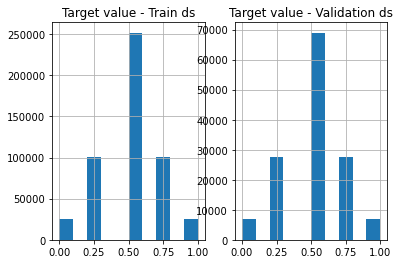

In [27]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['target'].hist(ax=ax[0]); 
df_valid['target'].hist(ax=ax[1]);
ax[0].set_title('Target value - Train ds');
ax[1].set_title('Target value - Validation ds');

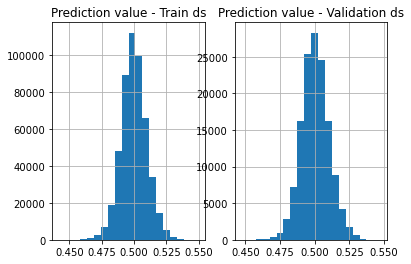

In [28]:
#plot histograms
fig, ax = plt.subplots(1, 2)
training_data['prediction'].hist(ax=ax[0], bins=20); 
df_valid['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Train ds');
ax[1].set_title('Prediction value - Validation ds');

In [29]:
count_train, division_train = np.histogram(training_data['prediction'], bins=20)
count_valid, division_valid = np.histogram(df_valid['prediction'], bins=20)
print ("Training data\n", count_train, division_train)
print ("Validation data\n", count_valid, division_valid)


Training data
 [     4     35    122    336    965   2436   6829  18850  48066  89645
 112362  99793  65950  34106  14522   5484   1740    447    106     10] [0.44223362 0.44759002 0.45294642 0.45830286 0.46365926 0.46901566
 0.47437206 0.47972846 0.4850849  0.4904413  0.4957977  0.5011541
 0.5065105  0.5118669  0.5172233  0.5225797  0.52793616 0.53329253
 0.53864896 0.54400533 0.54936177]
Validation data
 [    6    11    47   141   353   977  2777  7276 16223 25412 28300 24509
 16218  8789  4180  1744   628   150    34     4] [0.4474756  0.45246768 0.45745972 0.46245176 0.46744382 0.4724359
 0.47742793 0.48241997 0.48741204 0.4924041  0.49739614 0.5023882
 0.50738025 0.5123723  0.5173644  0.5223564  0.52734846 0.5323405
 0.53733253 0.5423246  0.5473167 ]


In [30]:
#Combine 
# Log target distributions with wandb
wandb.log({"target_prediction_valid": wandb.Histogram(df_valid['target'])})
wandb.log({"target_prediction_train": wandb.Histogram(training_data['target'])})
# Log prediction distributions with wandb
wandb.log({"target_prediction_valid": wandb.Histogram(df_valid['prediction'])})
wandb.log({"target_prediction_train": wandb.Histogram(training_data['prediction'])})

## 4.0 Predict for Submission
Not evaluating full tournamanet ds, due to no values in `target` field.

In [31]:
# define the feature columns
X_tournament = tournament_data[col_features]
y_tournament = tournament_data['target']

X_tournament.shape, y_tournament.shape

((1676742, 310), (1676742,))

View predictions: head and 3 tails (live, test, prev test)

In [32]:
tournament_data.loc[:,"prediction"] = model.predict(X_tournament)
tournament_data[['target','prediction']].head()

,target,prediction
0,0.25,0.488596
1,0.50,0.489448
2,1.00,0.521148
3,0.50,0.502109
4,0.75,0.500171


In [33]:
# submit predictions to numer.ai - manually?
tournament_data[["id", "prediction"]].to_csv("predictions.csv", index=False)

print ("Submission dataset completed time (in min).  Submission saved to csv.", (time.time() - t0)/60)

Submission dataset completed time (in min).  Submission saved to csv. 31.96267945766449


## Appendix

### Appendix A. Submission Post-EDA


#### Predictions

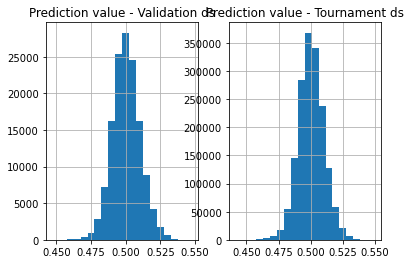

In [34]:
#plot histograms
fig, ax = plt.subplots(1, 2)
df_valid['prediction'].hist(ax=ax[0], bins=20);
tournament_data['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Validation ds');
ax[1].set_title('Prediction value - Tournament ds');

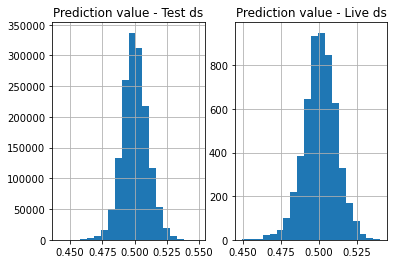

In [35]:
#plot histograms
fig, ax = plt.subplots(1, 2)
tournament_data[tournament_data['data_type']=='test']['prediction'].hist(ax=ax[0], bins=20);
tournament_data[tournament_data['data_type']=='live']['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Test ds');
ax[1].set_title('Prediction value - Live ds');

In [42]:
tournament_data['era_number'] = tournament_data['era'].str.slice(3)
df_tourn_test = tournament_data[tournament_data['data_type']=='test']
df_tourn_live = tournament_data[tournament_data['data_type']=='live']


In [43]:
count_tourn, division_tourn = np.histogram(tournament_data['prediction'], bins=20)
count_valid, division_valid = np.histogram(df_valid['prediction'], bins=20)
count_test, division_test = np.histogram(df_tourn_test['prediction'], bins=20)
count_live, division_live = np.histogram(df_tourn_live['prediction'], bins=20)

print ("Tournament data\n", count_tourn.sum(), count_tourn, division_tourn)
print ("Validation data\n", count_valid.sum(), count_valid, division_valid)
print ("Test data\n", count_test.sum(), count_test, division_test)
print ("Live data\n", count_live.sum(), count_live, division_live)

Tournament data
 1676742 [    11     65    242    770   2379   6343  18116  54345 146140 284661
 368355 341502 237503 128118  57836  21866   6647   1527    283     33] [0.4415604  0.44693345 0.4523065  0.45767957 0.46305263 0.4684257
 0.47379872 0.47917178 0.48454484 0.4899179  0.49529096 0.500664
 0.50603706 0.5114101  0.5167832  0.52215624 0.5275293  0.53290236
 0.5382754  0.5436485  0.54902154]
Validation data
 137779 [    6    11    47   141   353   977  2777  7276 16223 25412 28300 24509
 16218  8789  4180  1744   628   150    34     4] [0.4474756  0.45246768 0.45745972 0.46245176 0.46744382 0.4724359
 0.47742793 0.48241997 0.48741204 0.4924041  0.49739614 0.5023882
 0.50738025 0.5123723  0.5173644  0.5223564  0.52734846 0.5323405
 0.53733253 0.5423246  0.5473167 ]
Test data
 1533530 [    11     58    226    713   2172   5833  16586  49692 133943 260614
 337081 312144 217025 117049  52817  19892   5993   1395    256     30] [0.4415604  0.44693345 0.4523065  0.45767957 0.46305263 0

In [39]:
# Log ds counts with wandb
wandb.log({"count_train":training_data.shape[0], "count_tourn":count_tourn.sum(), "count_valid":count_valid.sum(), "count_test": count_test.sum(), "count_live": count_live.sum() })


In [40]:
# Log prediction distributions with wandb
wandb.log({"prediction_tourn": wandb.Histogram(tournament_data['prediction'])})
wandb.log({"prediction_test": wandb.Histogram(df_tourn_test['prediction'])})
wandb.log({"prediction_live": wandb.Histogram(df_tourn_live['prediction'])})

#### Previous Test
should be the same as the whole `test` during last round

In [44]:
era_test_max = int(tournament_data[tournament_data['data_type']=='test']['era_number'].max())
df_tourn_test_prev = df_tourn_test[df_tourn_test['era_number'] != str(era_test_max)]

print("Tournamnet - previous test: ", df_tourn_test_prev['era_number'].min(), df_tourn_test_prev['era_number'].max())

Tournamnet - previous test:  575 949


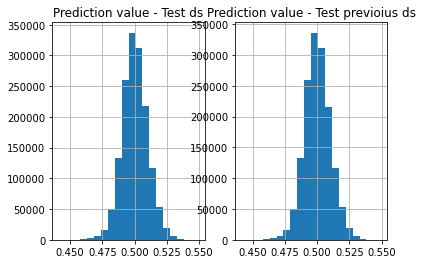

In [45]:
#plot histograms
fig, ax = plt.subplots(1, 2)
df_tourn_test['prediction'].hist(ax=ax[0], bins=20);
df_tourn_test_prev['prediction'].hist(ax=ax[1], bins=20);
ax[0].set_title('Prediction value - Test ds');
ax[1].set_title('Prediction value - Test previoius ds');

In [ ]:
count_test_prev, division_test_prev = np.histogram(df_tourn_test_prev['prediction'], bins=20)
print ("Test data\n", count_test.sum(), count_test, division_test)
print ("Test data - previous\n", count_test_prev.sum(), count_test_prev, division_test_prev)

Note: with 20 bins, bins are the same, counts are slightly different - smaller in previous test ds.

#### Predictions: tournament vs test vs previous test

In [46]:
print("Predictions tail: live", tournament_data[['target','prediction']].tail())
print("Predictions tail: test", df_tourn_test[['target','prediction']].tail())
print("Predictions tail: test previous", df_tourn_test_prev[['target','prediction']].tail())

Predictions tail: live          target  prediction
1676737     NaN    0.513692
1676738     NaN    0.513849
1676739     NaN    0.504091
1676740     NaN    0.507414
1676741     NaN    0.482952
Predictions tail: test          target  prediction
1671304     NaN    0.504341
1671305     NaN    0.500630
1671306     NaN    0.506465
1671307     NaN    0.481725
1671308     NaN    0.493580
Predictions tail: test previous          target  prediction
1665893     NaN    0.500586
1665894     NaN    0.493721
1665895     NaN    0.492104
1665896     NaN    0.492895
1665897     NaN    0.518308


In [47]:
wandb.finish()

training_time_minutes,7.87549
_runtime,2238
_timestamp,1616377560
_step,10
spearman_train,0.1422
payout_train,0.7098
numerai_sharpe_train,4.3293
mae_train,0.1522
spearman_valid,0.0234
payout_valid,0.117
numerai_sharpe_valid,0.7799


training_time_minutes,▁
_runtime,▁▃▃▄▄▄▄████
_timestamp,▁▃▃▄▄▄▄████
_step,▁▂▂▃▄▅▅▆▇▇█
spearman_train,▁
payout_train,▁
numerai_sharpe_train,▁
mae_train,▁
spearman_valid,▁
payout_valid,▁
numerai_sharpe_valid,▁


In [ ]:
mystop = 1

## Xtra

In [ ]:
if not mystop:
    
    def load_data0(directory: str, reduce_memory: bool=True) -> tuple:
        """
        Get data for current round
        :param directory: The path to the directory where the data needs to be saved
        :return: A tuple containing the datasets
        """
        print('Loading the data')
        full_path = f'{directory}/numerai_dataset_{NAPI.get_current_round()}/'
        train_path = full_path + 'numerai_training_data.csv'
        test_path = full_path + 'numerai_tournament_data.csv'
        train = pd.read_csv(train_path)
        test = pd.read_csv(test_path)

        # Reduce all features to 32-bit floats
        if reduce_memory:
            num_features = [f for f in train.columns if f.startswith("feature")]
            train[num_features] = train[num_features].astype(np.float32)
            test[num_features] = test[num_features].astype(np.float32)

        val = test[test['data_type'] == 'validation']
        return train, val, test